In [1]:
import pandas as pd
import string
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from wordcloud import WordCloud

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# nltk.download('stopwords')
# nltk.download('punkt')

# python3 bible-word-frequencies.py

In [2]:
# Load the dataset
df = pd.read_csv("./kjv-bible.csv")

df.head()

,id,b,c,v,t
0,1001001,1,1,1,In the beginning God created the heaven and th...
1,1001002,1,1,2,"And the earth was without form, and void; and ..."
2,1001003,1,1,3,"And God said, Let there be light: and there wa..."
3,1001004,1,1,4,"And God saw the light, that it was good: and G..."
4,1001005,1,1,5,"And God called the light Day, and the darkness..."


In [3]:
# Load the auxiliary dataset
df_auxiliary = pd.read_csv("./kjv-bible-books.csv")

df_auxiliary.head()

,Book,Tanakh,King James Version,New Jerusalem Version,Time,Period,Location
0,Acts,NaN,44.0,51,80,Christian,Rome
1,Amos,17.0,30.0,37,-745,Monarchic,Israel
2,Baruch,NaN,NaN,32,-180,Hellenistic,Israel
3,1 Chronicles,38.0,13.0,13,-350,Persian,Israel
4,2 Chronicles,39.0,14.0,14,-350,Persian,Israel


In [4]:
# Create enriched DataFrame
df_enriched = df_auxiliary.drop(['Tanakh','New Jerusalem Version'], axis=1)
df_enriched['King James Version'] = df_enriched['King James Version'].replace(np.nan, 0)
df_enriched['King James Version'] = df_enriched['King James Version'].astype('int')

df_enriched.head()

,Book,King James Version,Time,Period,Location
0,Acts,44,80,Christian,Rome
1,Amos,30,-745,Monarchic,Israel
2,Baruch,0,-180,Hellenistic,Israel
3,1 Chronicles,13,-350,Persian,Israel
4,2 Chronicles,14,-350,Persian,Israel


In [5]:
# Merge into original DataFrame
df = df.merge(df_enriched, left_on='b', right_on='King James Version')

df.head()

,id,b,c,v,t,Book,King James Version,Time,Period,Location
0,1001001,1,1,1,In the beginning God created the heaven and th...,Genesis,1,-500,Persian,Israel
1,1001002,1,1,2,"And the earth was without form, and void; and ...",Genesis,1,-500,Persian,Israel
2,1001003,1,1,3,"And God said, Let there be light: and there wa...",Genesis,1,-500,Persian,Israel
3,1001004,1,1,4,"And God saw the light, that it was good: and G...",Genesis,1,-500,Persian,Israel
4,1001005,1,1,5,"And God called the light Day, and the darkness...",Genesis,1,-500,Persian,Israel


In [6]:
# Create "testament" column based on the book number
df["t"] = df["t"].astype("str")
df.loc[df["b"] <= 39, "testament"] = "old"
df.loc[df["b"] > 39, "testament"] = "new"

In [7]:
# Lowercase the text
df["t"] = df["t"].str.lower()

In [8]:
# Create "num_words" column based on a given text's word count
df['num_words'] = df['t'].str.split().str.len()

df.head()

,id,b,c,v,t,Book,King James Version,Time,Period,Location,testament,num_words
0,1001001,1,1,1,in the beginning god created the heaven and th...,Genesis,1,-500,Persian,Israel,old,10
1,1001002,1,1,2,"and the earth was without form, and void; and ...",Genesis,1,-500,Persian,Israel,old,29
2,1001003,1,1,3,"and god said, let there be light: and there wa...",Genesis,1,-500,Persian,Israel,old,11
3,1001004,1,1,4,"and god saw the light, that it was good: and g...",Genesis,1,-500,Persian,Israel,old,17
4,1001005,1,1,5,"and god called the light day, and the darkness...",Genesis,1,-500,Persian,Israel,old,22


In [9]:
# Tokenize the text and remove stopwords and punctuation
sw = stopwords.words('english')
sw.extend(['from', 'upon','away','even','unto'])

stop_words = set(sw)

punctuations = set(string.punctuation)
word_tokens = df["t"].apply(word_tokenize)
filtered_words = word_tokens.apply(
    lambda x: [
        word
        for word in x
        if word.isalpha() and word not in stop_words and word not in punctuations
    ]
)

In [10]:
# Combine the filtered words with the 'testament' column
df["filtered_words"] = filtered_words

In [11]:
# Flatten the list of lists into a single list
df["filtered_words"] = df["filtered_words"].apply(lambda x: " ".join(x))

In [12]:
# Count word frequencies for each testament
word_freq_old_testament = Counter(
    " ".join(df[df["testament"] == "old"]["filtered_words"]).split()
)
word_freq_new_testament = Counter(
    " ".join(df[df["testament"] == "new"]["filtered_words"]).split()
)

In [13]:
# Get the 20 most common words for each testament
top_20_old_testament_words = dict(word_freq_old_testament.most_common(20))
top_20_new_testament_words = dict(word_freq_new_testament.most_common(20))

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [Text(0, 0, 'shall'),
  Text(1, 0, 'lord'),
  Text(2, 0, 'thou'),
  Text(3, 0, 'thy'),
  Text(4, 0, 'thee'),
  Text(5, 0, 'god'),
  Text(6, 0, 'said'),
  Text(7, 0, 'israel'),
  Text(8, 0, 'king'),
  Text(9, 0, 'ye'),
  Text(10, 0, 'son'),
  Text(11, 0, 'people'),
  Text(12, 0, 'man'),
  Text(13, 0, 'house'),
  Text(14, 0, 'hath'),
  Text(15, 0, 'land'),
  Text(16, 0, 'children'),
  Text(17, 0, 'came'),
  Text(18, 0, 'shalt'),
  Text(19, 0, 'day')])

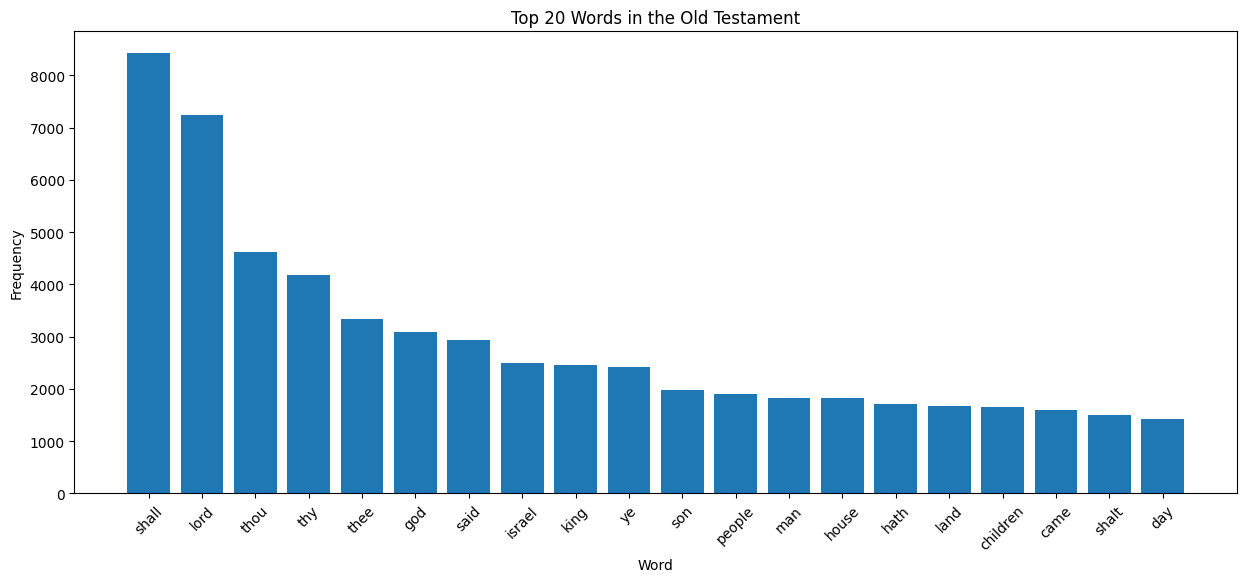

In [14]:
# Plot word frequency distribution for the Old Testament
plt.figure(figsize=(15, 6))
plt.subplot(1, 1, 1)
plt.bar(*zip(*top_20_old_testament_words.items()))
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.title("Top 20 Words in the Old Testament")
plt.xticks(rotation=45)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [Text(0, 0, 'ye'),
  Text(1, 0, 'shall'),
  Text(2, 0, 'god'),
  Text(3, 0, 'said'),
  Text(4, 0, 'jesus'),
  Text(5, 0, 'man'),
  Text(6, 0, 'thou'),
  Text(7, 0, 'things'),
  Text(8, 0, 'lord'),
  Text(9, 0, 'one'),
  Text(10, 0, 'also'),
  Text(11, 0, 'come'),
  Text(12, 0, 'christ'),
  Text(13, 0, 'hath'),
  Text(14, 0, 'came'),
  Text(15, 0, 'us'),
  Text(16, 0, 'thee'),
  Text(17, 0, 'saying'),
  Text(18, 0, 'say'),
  Text(19, 0, 'son')])

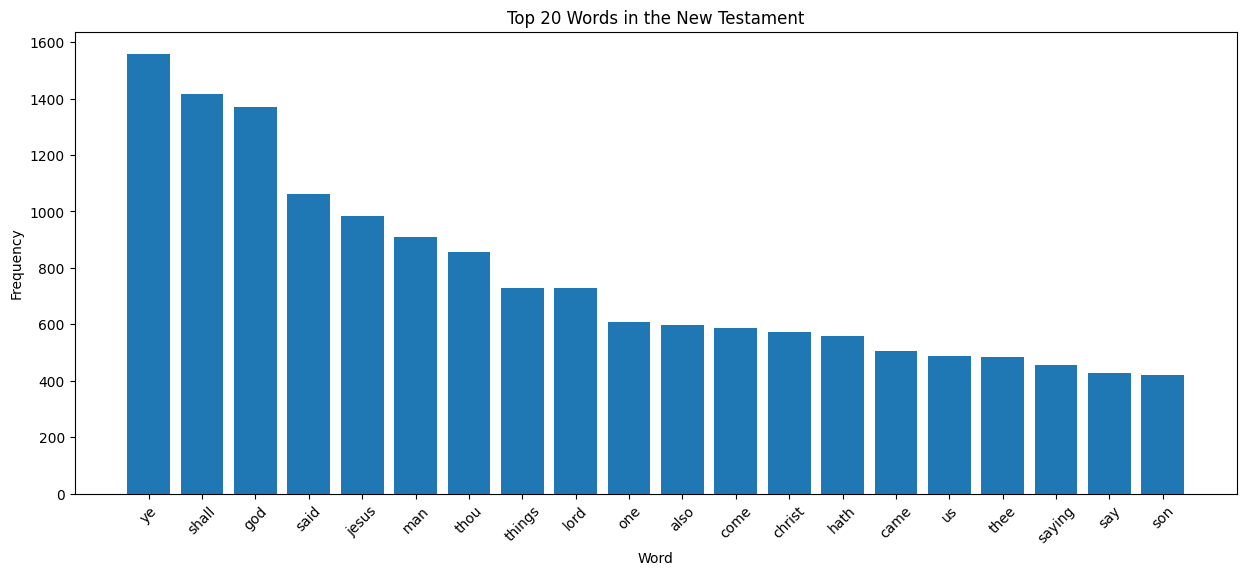

In [15]:
# Plot word frequency distribution for the Old Testament
plt.figure(figsize=(15, 6))
plt.subplot(1, 1, 1)
plt.bar(*zip(*top_20_new_testament_words.items()))
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.title("Top 20 Words in the New Testament")
plt.xticks(rotation=45)

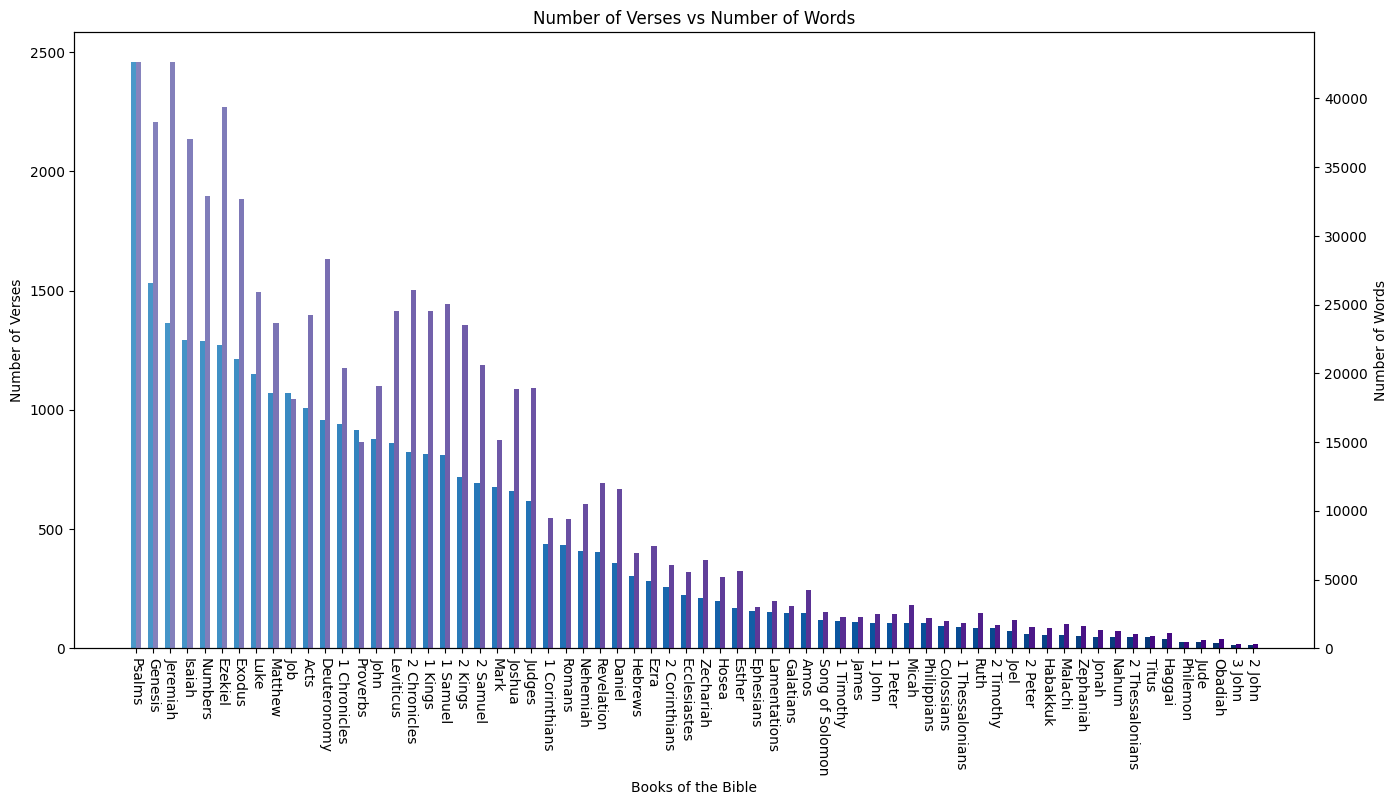

In [16]:
# Generating color gradients for visual distinction
color_1 = plt.cm.Blues(np.linspace(0.6, 1, 66))
color_2 = plt.cm.Purples(np.linspace(0.6, 1, 66))

# Grouping DataFrame by 'Book' column and aggregating counts and sum of words
words_versets = df.groupby('Book').agg({'b':'count', 'num_words':'sum'}).sort_values(by='b', ascending=False)

# Extracting data for plotting
data1 = words_versets['b']  # Number of verses
data2 = words_versets['num_words']  # Total number of words

# Creating a figure for plotting
plt.figure(figsize=(16, 8))

# Creating x-axis values
x = np.arange(66)

# Creating the first subplot (bar chart for number of verses)
ax1 = plt.subplot(1, 1, 1)
w = 0.3  # Width of bars

# Plotting number of verses
color = color_1
plt.title('Number of Verses vs Number of Words')
plt.xticks(x + w / 2, data1.index, rotation=-90)
ax1.set_xlabel('Books of the Bible')
ax1.set_ylabel('Number of Verses')
ax1.bar(x, data1.values, color=color_1, width=w, align='center')

# Creating the second subplot (bar chart for number of words)
ax2 = ax1.twinx()

# Plotting number of words
color = color_2
ax2.set_ylabel('Number of Words')
ax2.bar(x + w, data2, color=color_2, width=w, align='center')

# Displaying the plot
plt.show()

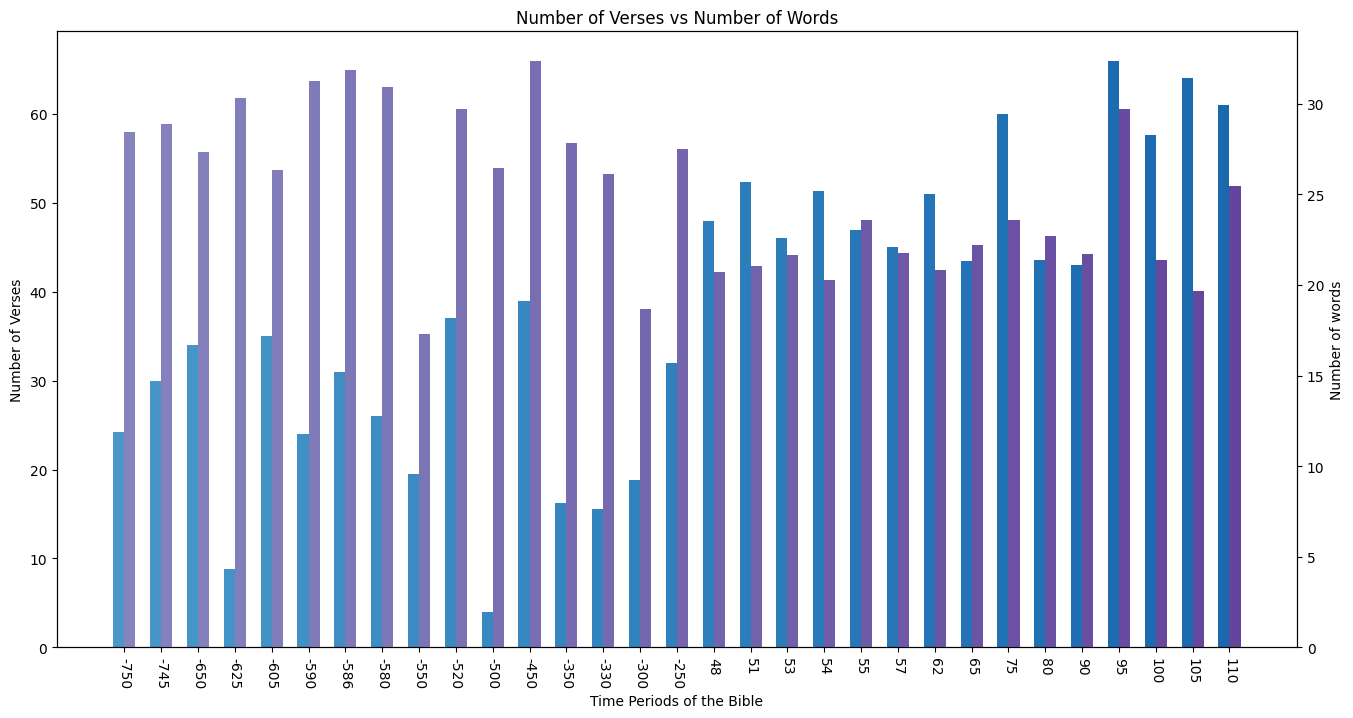

In [17]:
# Generating color gradients for visual distinction
color_1 = plt.cm.Blues(np.linspace(0.6, 1, 66))
color_2 = plt.cm.Purples(np.linspace(0.6, 1, 66))

# Grouping DataFrame by 'Time' column and aggregating mean values
words_versets_ = df.groupby('Time').agg({'b':'mean', 'num_words':'mean', 'Time':'mean'})

# Extracting data for plotting
data1 = words_versets_['b']  # Mean number of verses
data2 = words_versets_['num_words']  # Mean number of words

# Creating a figure for plotting
plt.figure(figsize=(16, 8))

# Creating x-axis values
x = np.arange(31)

# Creating the first subplot (bar chart for mean number of verses)
ax1 = plt.subplot(1, 1, 1)
w = 0.3  # Width of bars

# Plotting mean number of verses
color = color_1
plt.title('Number of Verses vs Number of Words')
plt.xticks(x + w / 2, data1.index, rotation=-90)
ax1.set_xlabel('Time Periods of the Bible')
ax1.set_ylabel('Number of Verses')
ax1.bar(x, data1.values, color=color_1, width=w, align='center')

# Creating the second subplot (bar chart for mean number of words)
ax2 = ax1.twinx()

# Plotting mean number of words
color = color_2
ax2.set_ylabel('Number of words')
ax2.bar(x + w, data2, color=color_2, width=w, align='center')

# Displaying the plot
plt.show()

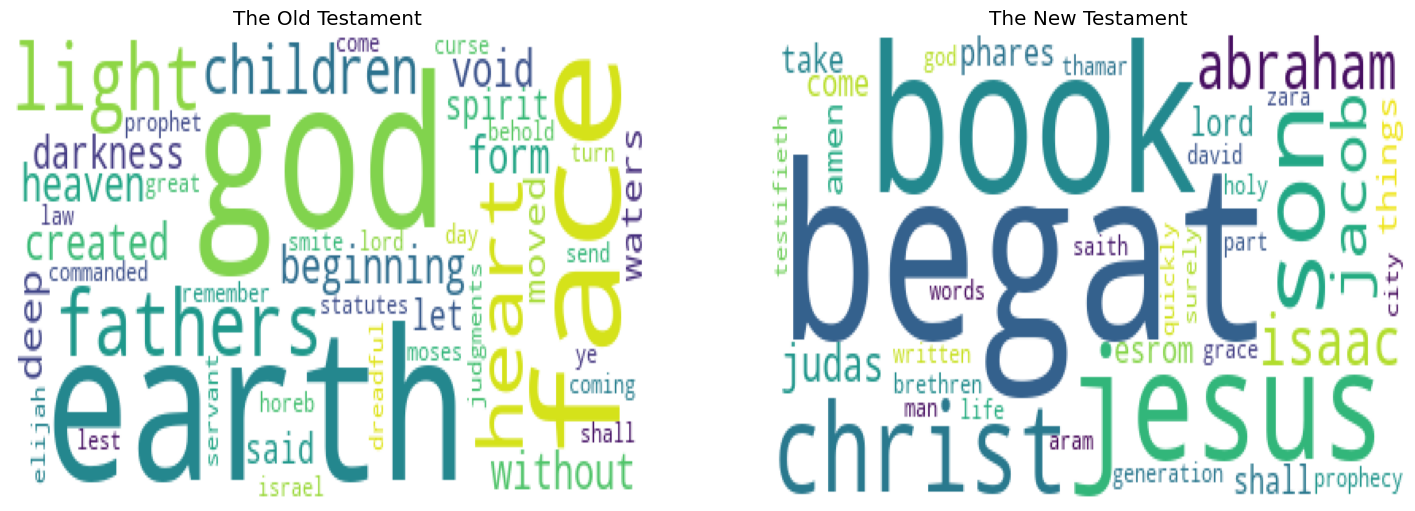

In [18]:
# Setting matplotlib parameters for figure size, font size, and subplot bottom margin
mpl.rcParams['figure.figsize'] = (10, 10)
mpl.rcParams['font.size'] = 12
mpl.rcParams['figure.subplot.bottom'] = 0.1

# Filtering DataFrame for verses with fewer than 40 words (Old Testament) and 40 words or more (New Testament)
old_testament = df[df.b < 40]
new_testament = df[df.b >= 40]

# Generating word clouds for Old Testament and New Testament
old_wordCloud = WordCloud(background_color='white', stopwords=sw).generate(str(old_testament.t.values))
new_wordCloud = WordCloud(background_color='white', stopwords=sw).generate(str(new_testament.t.values))

# Creating subplots to display word clouds side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
ax0, ax1 = ax.flatten()

# Displaying word cloud for the Old Testament
ax0.imshow(old_wordCloud, aspect="auto")
ax0.title.set_text('The Old Testament')
ax0.axis('off')

# Displaying word cloud for the New Testament
ax1.imshow(new_wordCloud, aspect="auto")
ax1.title.set_text('The New Testament')
ax1.axis('off')

# Showing the plot
plt.show()

In [19]:
df.columns

Index(['id', 'b', 'c', 'v', 't', 'Book', 'King James Version', 'Time',
       'Period', 'Location', 'testament', 'num_words', 'filtered_words'],
      dtype='object')

In [20]:
# Lowercase all DataFrame column names
df = df.rename(columns=lambda x: x.lower())

# Rename some column names
df = df.rename(columns={'b': 'book_num'})
df = df.rename(columns={'c': 'chapter'})
df = df.rename(columns={'v': 'verse'})
df = df.rename(columns={'t': 'text'})
df = df.rename(columns={'book': 'book_name'})
df = df.rename(columns={'king james version': 'kjv'})

df.columns

Index(['id', 'book_num', 'chapter', 'verse', 'text', 'book_name', 'kjv',
       'time', 'period', 'location', 'testament', 'num_words',
       'filtered_words'],
      dtype='object')

In [21]:
df.head()

,id,book_num,chapter,verse,text,book_name,kjv,time,period,location,testament,num_words,filtered_words
0,1001001,1,1,1,in the beginning god created the heaven and th...,Genesis,1,-500,Persian,Israel,old,10,beginning god created heaven earth
1,1001002,1,1,2,"and the earth was without form, and void; and ...",Genesis,1,-500,Persian,Israel,old,29,earth without form void darkness face deep spi...
2,1001003,1,1,3,"and god said, let there be light: and there wa...",Genesis,1,-500,Persian,Israel,old,11,god said let light light
3,1001004,1,1,4,"and god saw the light, that it was good: and g...",Genesis,1,-500,Persian,Israel,old,17,god saw light good god divided light darkness
4,1001005,1,1,5,"and god called the light day, and the darkness...",Genesis,1,-500,Persian,Israel,old,22,god called light day darkness called night eve...
